In [1]:
import ast
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

import torch
import torch.nn as nn
from torch.nn.functional import pairwise_distance

from sklearn.metrics import f1_score, precision_score, recall_score

# Siamese model

In [2]:
class SiameseNetwork(nn.Module):
    def __init__(self, input_size, embedding_size=128):
        super(SiameseNetwork, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(input_size, 512),
            nn.ReLU(),
            nn.Dropout(p=0.2),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(p=0.2),
            nn.Linear(256, embedding_size),
        )
    
    def forward(self, x):
        x = self.fc(x)
        return x

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

weights_path = '/kaggle/input/siamese-triplets/pytorch/final-training/6/5_epoch_3linear_dropout_lr_5.pt'
siamese_model = SiameseNetwork(input_size=768, embedding_size=128).to(device)
siamese_model.load_state_dict(torch.load(weights_path, map_location=device))
siamese_model.eval()

SiameseNetwork(
  (fc): Sequential(
    (0): Linear(in_features=768, out_features=512, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=512, out_features=256, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.2, inplace=False)
    (6): Linear(in_features=256, out_features=128, bias=True)
  )
)

# Load dataset

1. Load training triplet dataset
2. Load training dataset with BLIP embeddings

In [4]:
# types
df_train_dtype = {
    'similar': 'str',
    'anchor':'str',
    'dissimilar':'str',
    'similar_group': 'Int64',
    'dissimilar_group': 'Int64'
}

df_train_blip_dtype = {
    'image_path': 'str',
    'blip': 'object'
}

In [5]:
df_train_blip = pd.read_csv('/kaggle/input/new-cds-triplets-images/training_with_blip.csv', dtype=df_train_blip_dtype)

# Get centroid embeddings for each group

In [6]:
df_train_blip = df_train_blip.set_index('image_path') # for faster lookup
df_train_blip['blip_siamese'] = None

In [7]:
centroid_columns=['group', 'blip_centroid', 'blip_siamese_centroid']
df_train_centroid = pd.DataFrame(columns=centroid_columns)
df_train_centroid['group'] = pd.Series(dtype='Int64')
df_train_centroid['blip_centroid'] = pd.Series(dtype='object')
df_train_centroid['blip_siamese_centroid'] = pd.Series(dtype='object')

df_train_centroid = df_train_centroid.set_index('group') # for faster lookup

In [8]:
unique_training_groups = df_train_blip['group'].unique()

## Base BLIP model
Get centroid embedding for each group with the BLIP model \
Store the embedding under the `blip_centroid` column

In [9]:
for group in unique_training_groups:
    df_group = df_train_blip[df_train_blip['group'] == group]
    group_embeddings = [np.array(ast.literal_eval(embedding)) for embedding in df_group['blip']]
    df_train_centroid.at[group, 'blip_centroid'] = np.mean(group_embeddings, axis=0).tolist()

## Custom Siamese model
Get the embedding of each group with our custom Siamese model \
Store the embedding under the `blip_siamese_centroid` column

In [10]:
# getting blip_siamese
with torch.no_grad():
    for image_path,row in df_train_blip.iterrows():
        blip_embedding = ast.literal_eval(row['blip'])
        blip_embedding = torch.tensor(blip_embedding).float().to(device)
        
        siamese_embedding = siamese_model(blip_embedding)
        siamese_embedding = siamese_embedding.cpu().squeeze(0)

        df_train_blip.at[image_path, 'blip_siamese'] = siamese_embedding.numpy()

# getting blip_siamese_centroid
for group in unique_training_groups:
    df_group = df_train_blip[df_train_blip['group'] == group]
    group_siamese_embeddings = [np.array(embedding) for embedding in df_group['blip_siamese']]
    df_train_centroid.at[group, 'blip_siamese_centroid'] = np.mean(group_siamese_embeddings, axis=0).tolist()

# Evaluation with test dataset

## Load test dataset

In [11]:
df_testing_blip = pd.read_csv('/kaggle/input/new-cds-triplets-images/testing_with_blip.csv')
df_testing_blip['blip_siamese'] = pd.Series(dtype='object')
df_testing_blip['predicted_group_blip'] = None # int
df_testing_blip['predicted_group_siamese'] = None # int

testing_size = len(df_testing_blip)
df_testing_blip = df_testing_blip.sample(n=testing_size, random_state=42).reset_index(drop=True).set_index('image_path')

## Feed test dataset to custom Siamese model and get predicted group

In [12]:
def find_closest_group(embedding, centroid_embeddings):
    min_distance = float('inf')
    closest_group = None
    embedding = torch.tensor(embedding).float()
    for group, ref_embedding in centroid_embeddings.items():
        ref_embedding = torch.tensor(ref_embedding).float()
        distance = pairwise_distance(embedding.unsqueeze(0), ref_embedding.unsqueeze(0))
        if distance < min_distance:
            min_distance = distance
            closest_group = group
    return closest_group

1. BLIP model
2. Siamese model

In [13]:
centroid_blip = df_train_centroid.groupby('group')['blip_centroid'].first().to_dict()
centroid_blip_siamese = df_train_centroid.groupby('group')['blip_siamese_centroid'].first().to_dict()

for image_path, row in df_testing_blip.iterrows():
    blip_embedding = ast.literal_eval(row['blip'])
    features = torch.tensor(blip_embedding).float()
    
    # blip model
    predicted_group_blip = find_closest_group(features, centroid_blip)
    df_testing_blip.at[image_path, 'predicted_group_blip'] = predicted_group_blip
    
    # siamese model
    with torch.no_grad():
        embedding_siamese = siamese_model(features.to(device).unsqueeze(0))
    test_embedding = embedding_siamese.cpu().squeeze(0)
    df_testing_blip.at[image_path, 'blip_siamese'] = test_embedding.numpy()

    predicted_group_siamese = find_closest_group(test_embedding, centroid_blip_siamese)
    df_testing_blip.at[image_path, 'predicted_group_siamese'] = predicted_group_siamese

/tmp/ipykernel_18/459130396.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  embedding = torch.tensor(embedding).float()


In [14]:
df_testing_blip.head()

,Unnamed: 0,group,blip,blip_siamese,predicted_group_blip,predicted_group_siamese
image_path,,,,,,
sofas/3-seaters/50652_image_0_resized.jpg,215,98,"[-0.3173569142818451, -0.2179298847913742, -0....","[0.09274763, -0.17020634, -0.016324036, 0.4346...",454,93
sofas/4-seaters-up/91670_image_0_resized.jpg,66,115,"[-0.32920700311660767, -0.34030190110206604, -...","[0.14787674, -0.10691205, -0.15376288, 0.50247...",326,326
sofas/l-shape/90114_image_0_resized.jpg,9,313,"[0.04182377830147743, 0.07722572237253189, 0.0...","[0.02688475, -0.074609704, -0.17422974, 0.3377...",78,78
sofas/3-seaters/81171_image_0_resized.jpg,200,85,"[0.16512127220630646, -0.022468795999884605, 0...","[0.19268823, -0.17227653, -0.11429637, 0.45596...",14,62
sofas/leather-sofas/92125_image_0_resized.jpg,15,326,"[-0.13881005346775055, -0.44957107305526733, 0...","[0.16982028, -0.053061016, -0.11718573, 0.4793...",120,115


### Calculate F1, precision and recall score
1. BLIP model
2. Siamese model

In [15]:
true_groups = [x for x in df_testing_blip['group'].tolist()]
predicted_groups_blip = df_testing_blip['predicted_group_blip'].tolist()
predicted_groups_siamese = df_testing_blip['predicted_group_siamese'].tolist()

In [16]:
average_method = 'weighted'

f1_blip = f1_score(true_groups, predicted_groups_blip, average=average_method)
precision_blip = precision_score(true_groups, predicted_groups_blip, average=average_method)
recall_blip = recall_score(true_groups, predicted_groups_blip, average=average_method)

f1_siamese = f1_score(true_groups, predicted_groups_siamese, average=average_method)
precision_siamese = precision_score(true_groups, predicted_groups_siamese, average=average_method)
recall_siamese = recall_score(true_groups, predicted_groups_siamese, average=average_method)

print(f"Precision Score for BLIP: {precision_blip:.2f}")
print(f"Precision Score for Siamese: {precision_siamese:.2f}\n")

print(f"Recall Score for BLIP: {recall_blip:.2f}")
print(f"Recall Score for Siamese: {recall_siamese:.2f}\n")

print(f"F1 Score for BLIP: {f1_blip:.2f}")
print(f"F1 Score for Siamese: {f1_siamese:.2f}")

Precision Score for BLIP: 0.46
Precision Score for Siamese: 0.45

Recall Score for BLIP: 0.36
Recall Score for Siamese: 0.32

F1 Score for BLIP: 0.37
F1 Score for Siamese: 0.34


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall

## Find top 5 similar products
For each test image, compare it against the entire training set and find the top 5 nearest images

In [17]:

def display_image_grid(results, n, label='', save_path='results_grid.png'):
   
    num_rows = n
    num_columns = 6  # 1 test image + 5 training images
    
    fig, axs = plt.subplots(nrows=num_rows, ncols=num_columns, figsize=(20, 10))
    
    for i, result in enumerate(results[:n]):
        validation_image = Image.open('/kaggle/input/cds-sofas-chairs-test/test/' + result[0])
        axs[i, 0].imshow(validation_image)
        axs[i, 0].set_title("Validation")
        axs[i, 0].axis('off')
        
        for j, training_image_path in enumerate(result[1], start=1):
            training_image = Image.open('/kaggle/input/cds-sofas-chairs-training/training/' + training_image_path)
            axs[i, j].imshow(training_image)
            axs[i, j].set_title(f"Top {j}")
            axs[i, j].axis('off')
    
    plt.tight_layout()
    plt.savefig(f'{label}_{save_path}')
    plt.show()

In [ ]:
blip_results = []
siamese_results = []

train_blip_embeddings = torch.stack([torch.tensor(ast.literal_eval(embedding)) for embedding in df_train_blip['blip']])
train_siamese_embeddings = torch.stack([torch.tensor(embedding) for embedding in df_train_blip['blip_siamese']])

for image_path, row in df_testing_blip.iterrows():
    
    test_blip_embedding = torch.tensor(ast.literal_eval(row['blip'])).unsqueeze(0)
    test_siamese_embedding = torch.tensor(row['blip_siamese']).unsqueeze(0)  # Add batch dimension if not already a tensor
    
    blip_distances = pairwise_distance(test_blip_embedding, train_blip_embeddings)
    siamese_distances = pairwise_distance(test_siamese_embedding, train_siamese_embeddings)
    
    _, top_5_indices_blip = torch.topk(blip_distances, 5, largest=False)
    top_5_image_paths_blip = df_train_blip.iloc[top_5_indices_blip.cpu().tolist()].index.tolist()
    
    _, top_5_indices_siamese = torch.topk(siamese_distances, 5, largest=False)
    top_5_image_paths_siamese = df_train_blip.iloc[top_5_indices_siamese.cpu().tolist()].index.tolist()

    blip_results.append((image_path, top_5_image_paths_blip))
    siamese_results.append((image_path, top_5_image_paths_siamese))

Display results

BLIP


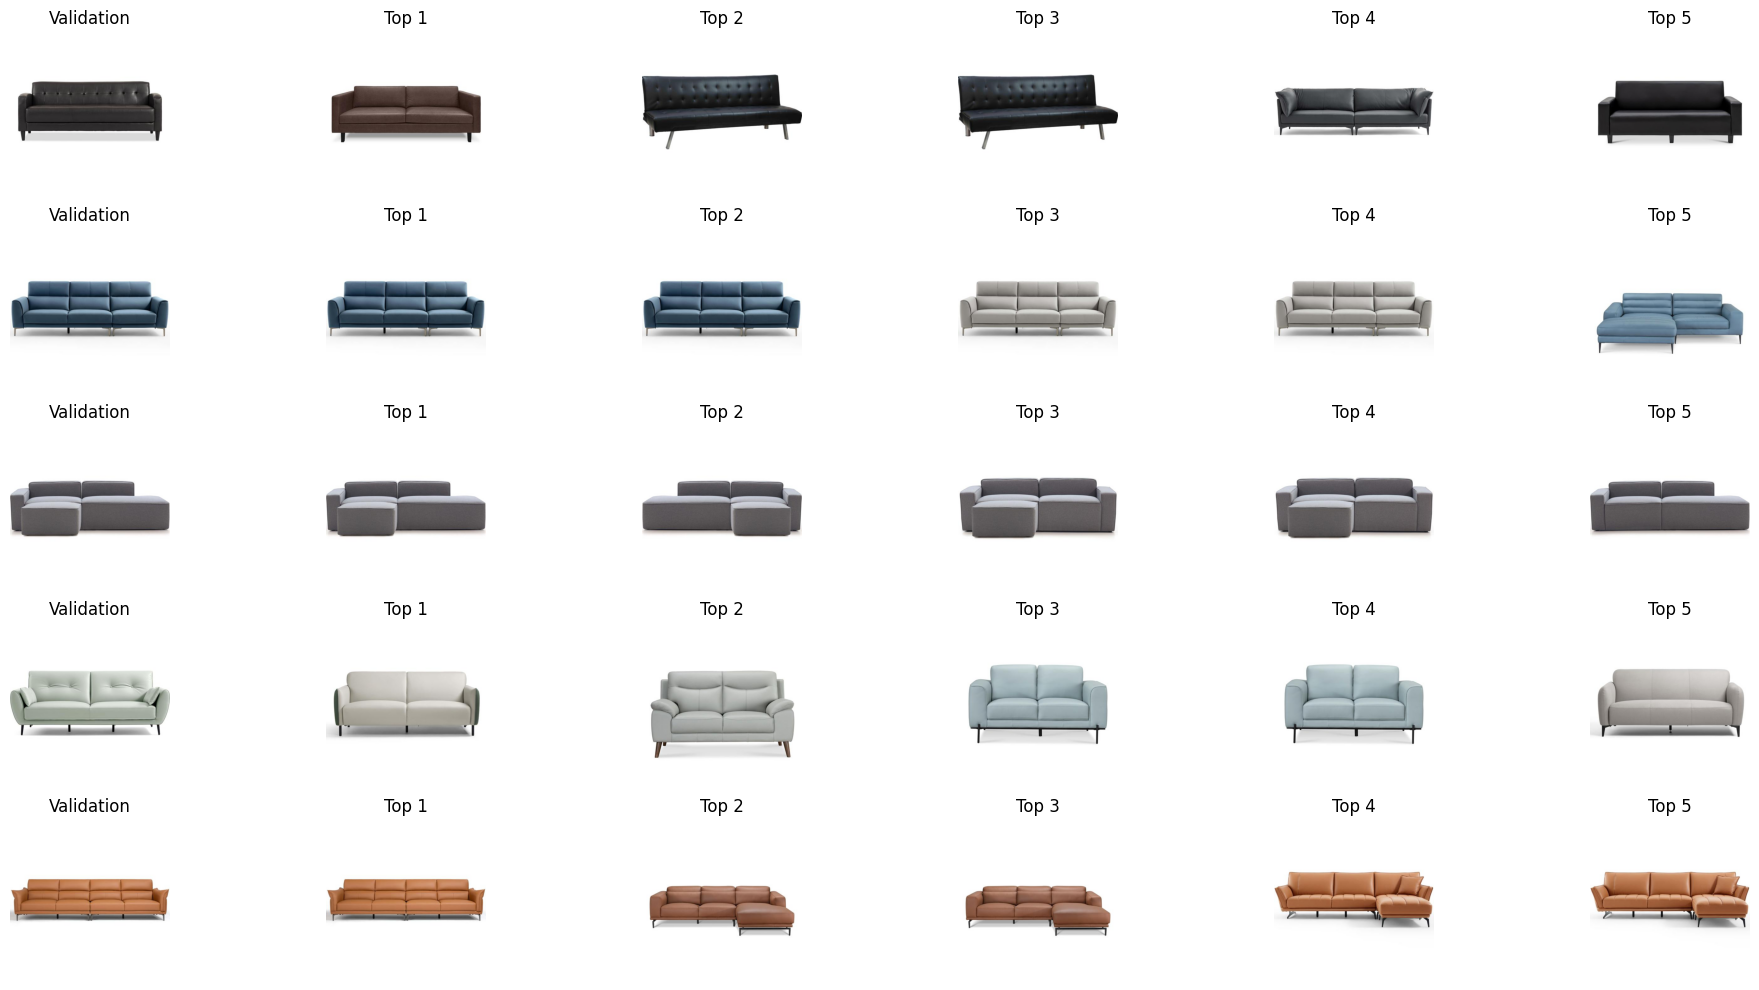


SIAMESE


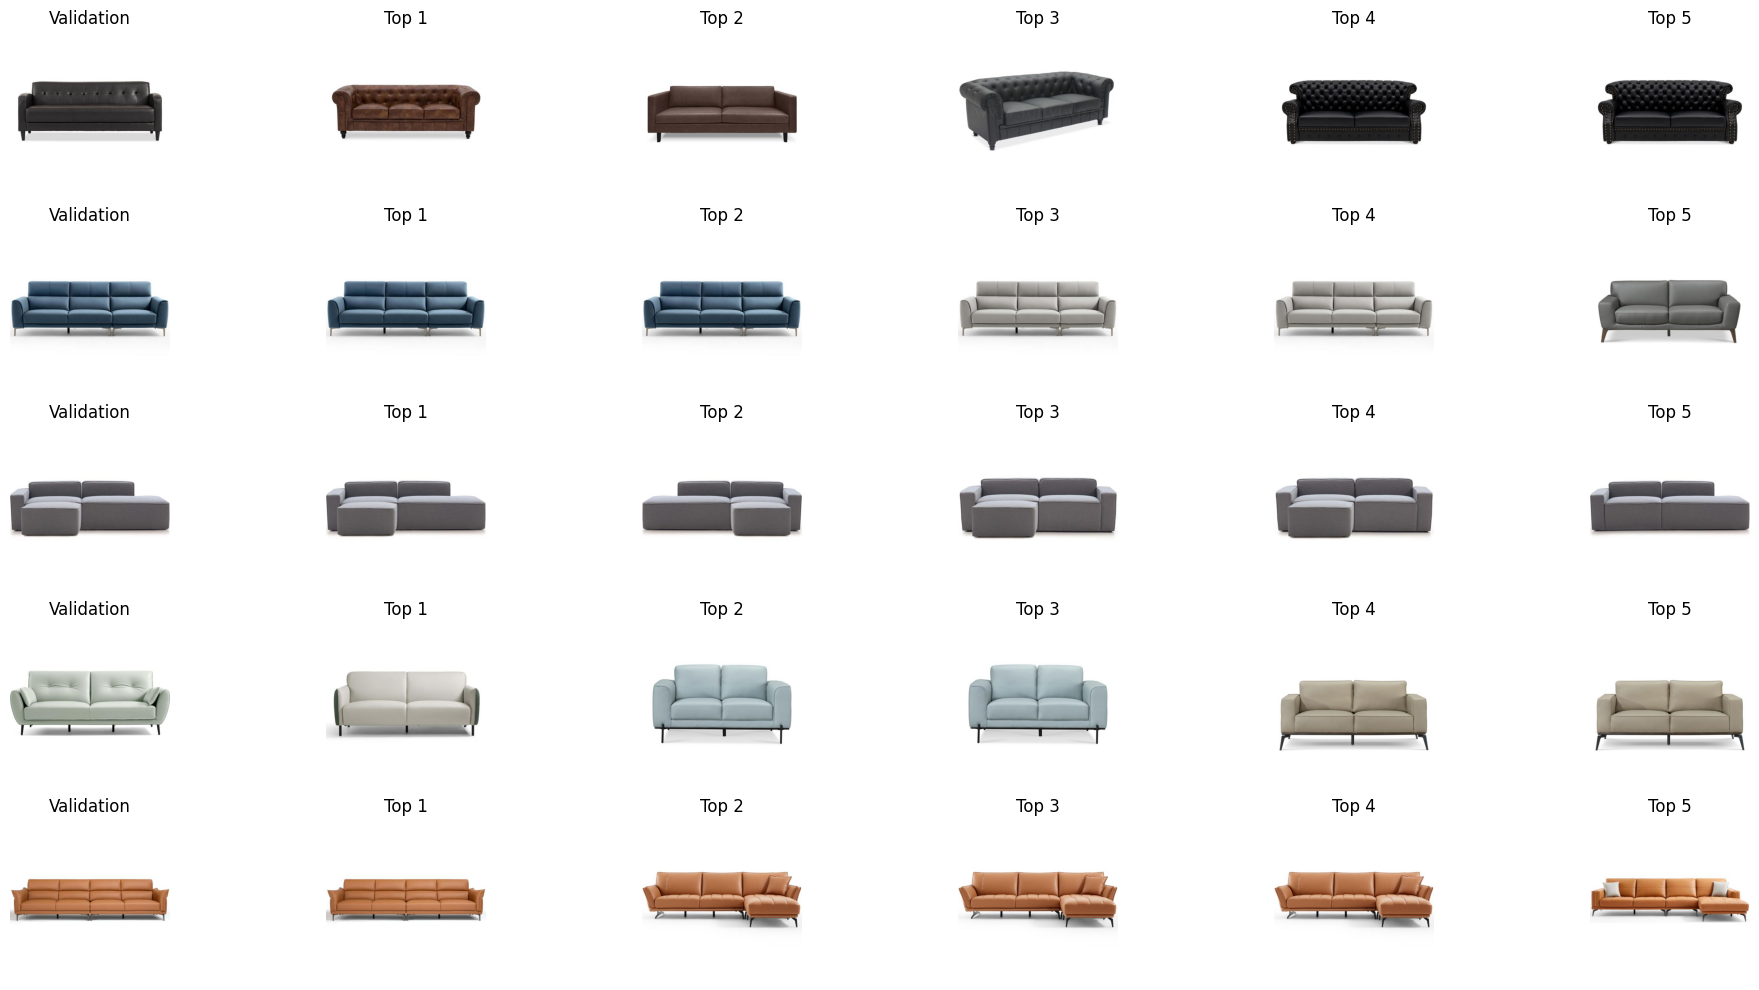

In [19]:
print("BLIP")
display_image_grid(blip_results, n=5, label="BLIP")

print("\nSIAMESE")
display_image_grid(siamese_results, n=5, label="Siamese")

# Visualise with dot cluster map

In [20]:
from sklearn.manifold import TSNE

num_samples = df_train_blip.shape[0]
embeddings = np.stack(df_train_blip['blip_siamese'].values)
group_labels = np.stack(df_train_blip['group'].values)

tsne = TSNE(n_components=2, random_state=42)
embeddings_2d = tsne.fit_transform(embeddings)

df_2d = pd.DataFrame(embeddings_2d, columns=['x', 'y'])
df_2d['group_labels'] = group_labels


/tmp/ipykernel_18/2789116499.py:28: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout(rect=[0, 0, 0.85, 1])  # Adjust the right side of the layout to make room for the legend


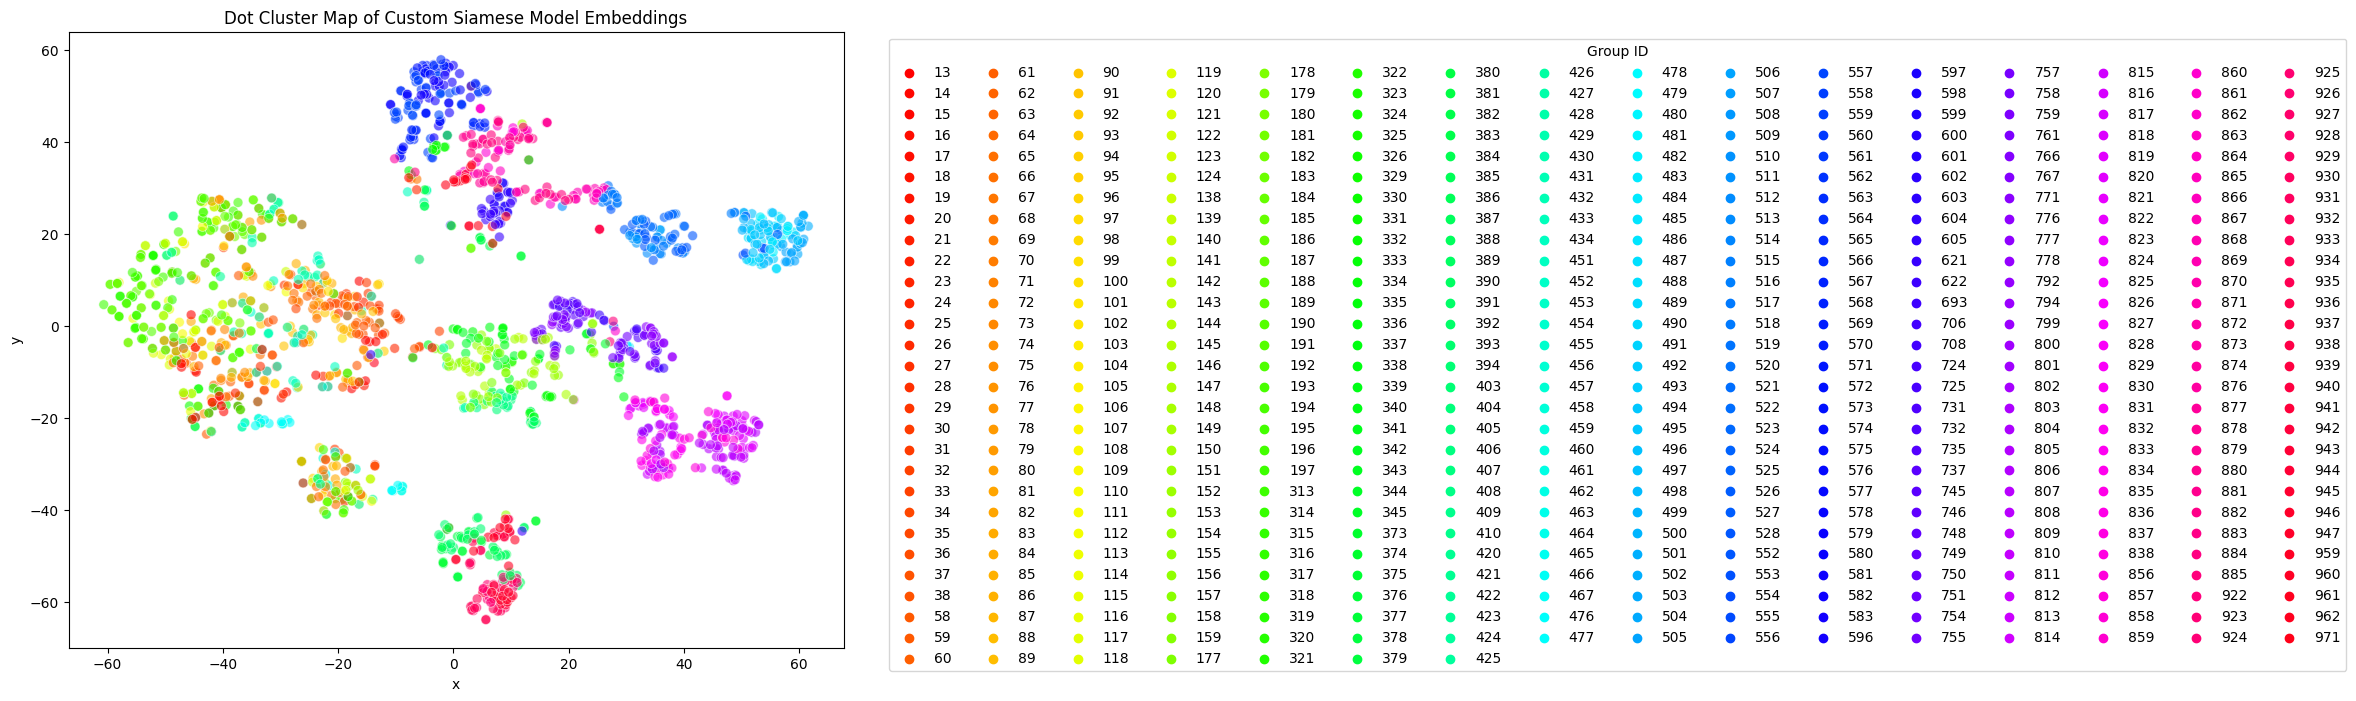

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns

unique_labels = df_2d['group_labels'].unique()
n_unique_labels = len(unique_labels)

palette = sns.color_palette("hsv", n_unique_labels)
color_map = {label: color for label, color in zip(unique_labels, palette)}

plt.figure(figsize=(10, 8))
sns.scatterplot(
    data=df_2d, 
    x='x', y='y', 
    hue='group_labels', 
    palette=color_map,
    s=50, alpha=0.6
).set(title='Dot Cluster Map of Custom Siamese Model Embeddings')

ncol_legend = int(n_unique_labels / 30) + 1

plt.legend(title='Group ID', bbox_to_anchor=(1.05, 1), loc='upper left', ncol=ncol_legend)

plt.tight_layout(rect=[0, 0, 0.85, 1])
plt.savefig('scatter_plot.png', bbox_inches='tight')
plt.show()